## THƯ VIỆN

In [1]:
import pandas as pd
import numpy as np
import random
import itertools

from matplotlib import pyplot as plt 
from nameparser import HumanName
from fuzzywuzzy import fuzz, process
from sklearn.cluster import DBSCAN
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, StructType, IntegerType, StructField
from pyspark.sql.functions import lower, split, col, when, explode, count, pandas_udf, PandasUDFType

spark = SparkSession.builder.master('local').appName("Book Recommend System").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

## TIỀN XỬ LÝ DỮ LIỆU

### DỮ LIỆU SÁCH (BX_Books.csv)

Tập dữ liệu sách `BX_Books.csv` bao gồm các cột:
- `ISBN`: Mã số chuẩn quốc tế của sách
- `Book-Title`: Tựa đề sách
- `Book-Author`: Tác giả của sách
- `Year-Of-Publication`: Năm xuất bản của sách
- `Publisher`: Nhà xuất bản
- `Image-URL-S`: URL hình ảnh sách (nhỏ)
- `Image-URL-M`: URL hình ảnh sách (vừa)
- `Image-URL-L`: URL hình ảnh sách (lớn)

Trong số các cột chỉ có 3 cột ta quan tâm, là `ISBN`, `Book-Title` và `Book-Author`. Các cột còn lại ta bỏ qua.

In [2]:
books_df = pd.read_csv('data/BX_Books.csv', delimiter=';', encoding='ISO-8859-1')
books_df = books_df[['ISBN', 'Book-Title', 'Book-Author']]
books_df.head()

,ISBN,Book-Title,Book-Author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


Tiếp theo, ta kiểm tra giá trị bị thiếu trong từng cột.

In [3]:
books_df[books_df['ISBN'].isna()]

,ISBN,Book-Title,Book-Author


In [4]:
books_df[books_df['Book-Title'].isna()]

,ISBN,Book-Title,Book-Author


In [5]:
books_df[books_df['Book-Author'].isna()]

,ISBN,Book-Title,Book-Author
118038,0751352497,A+ Quiz Masters:01 Earth,NaN
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN


Ta thấy chỉ có một ít dòng thiếu giá trị `Book-Author` nên ta điền thủ công.

Nguồn:
- [Google Books - A+ Quiz Masters:01 Earth](https://www.google.com.vn/books/edition/A+_Quiz_Masters/eas_PQAACAAJ?hl=vi)
- [Google Books - The Credit Suisse Guide to Managing Your Personal Wealth](https://www.google.com.vn/books/edition/The_Credit_Suisse_Guide_to_Managing_Your/4zx8AAAACAAJ)

In [6]:
books_df['Book-Author'][118038] = 'Penguin Books'
books_df['Book-Author'][187700] = 'Larissa Downes, Sophie Pyott'
books_df[books_df['Book-Author'].isna()]

,ISBN,Book-Title,Book-Author


Tiếp theo, ta thực hiện một số thao tác trên chuỗi đối với 2 cột `Book-Title` và `Book-Author`:
- Đưa về dạng viết thường và loại bỏ khoảng trắng thừa đối với cả 2 cột.
- Đối với `Book-Author`, một sách có thể do nhiều tác giả tham gia viết. Trong trường hợp này, tên các tác giả được ngăn cách bởi dấu phẩy. Ta thực hiện tách các tên tác giả ra và đưa về dạng danh sách.
- Đối với từng tên tác giả, ta rút gọn chúng nhằm làm giảm số lượng giá trị khác nhau. Cụ thể, ta loại bỏ tên đệm, chỉ giữ họ và tên (nếu có).

In [7]:
def normalize_name(name):
    hn = HumanName(name)
    return (hn.first + ' ' + hn.last).strip(' ')

books_df['Book-Author'] = books_df['Book-Author'].str.lower().str.strip(' ').str.split(', ').apply(lambda names: [normalize_name(name) for name in names])
books_df['Book-Title']  = books_df['Book-Title'].str.lower().str.strip(' ')

books_df.head()

,ISBN,Book-Title,Book-Author
0,0195153448,classical mythology,[mark morford]
1,0002005018,clara callan,[richard wright]
2,0060973129,decision in normandy,[carlo d'este]
3,0374157065,flu: the story of the great influenza pandemic...,[gina kolata]
4,0393045218,the mummies of urumchi,[e. barber]


Tiếp theo, ta xem xét thử trường hợp các cuốn sách trùng tên `Little Women`.

In [8]:
books_df[books_df['Book-Title'] == 'little women']

,ISBN,Book-Title,Book-Author
3952,185854176X,little women,[louisa atcott]
4330,0861782356,little women,[louisa alcott]
6100,0671517643,little women,[louisa alcott]
12228,0590203509,little women,[louisa alcott]
20677,0440447682,little women,[louisa alcott]
22456,0020412401,little women,[louisa alcott]
32838,1550134140,little women,[louisa alcott]
52213,0451529308,little women,[louisa alcott]
52554,0451518144,little women,[louisa alcott]
53361,0590437976,little women,[louisa alcott]


Ta nhận thấy các cuốn sách này cùng tác giả, chỉ khác nhau ở cách viết (có hoặc không có họ, họ viết trước hoặc sau tên, ...).

Để thống nhất tên tác giả, ta cần phải thay thế các tên tác giả bằng tên khác có độ tương đồng cao xuất hiện trước nó. Độ tương đồng được tính bằng thuật toán `Fuzzy Matching`.

In [9]:
authors = np.array(list(set(books_df['Book-Author'].explode())))

def first_match(item, items, threshold=90, depth=0):
    gen = process.extractWithoutOrder(item, items, scorer=fuzz.token_set_ratio, score_cutoff=threshold)
    result = next(gen, (item,))[0]

    return result

first_match('alcott', authors)

'lousa alcott'

In [10]:
authors.shape

(93348,)

Trong dữ liệu này có hơn 90000 tên tác giả khác nhau, tức là khá nhiều để xử lý trực tiếp. Chính vì thế, ta sử dụng `pyspark` để phân chia dữ liệu thành nhiều cụm phân tán và dùng nhiều core để xử lý song song.

Bước đầu tiên là chia tập tên tác giả thành từng cụm sao cho các tên gần giống nhau nằm trong 1 cụm.

In [11]:
def partition(items, n=2000):
    if len(items) == 0:
        return []

    if len(items) <= 2000:
        return [items]

    selected = random.choice(items)
    sims = np.array([fuzz.ratio(selected, item) for item in items])
    idxs = sims.argsort()[-n:][::-1]
    return [items[idxs]] + partition(np.delete(items, idxs), n=n)

authors_partition = partition(authors)
len(authors_partition)

47

Tiếp theo ta tạo dataframe `pyspark` bao gồm 2 cột:
- `Author`: tên tác giả
- `Partition`: ID cụm

In [12]:
partition_index = []
for index, author_groups in enumerate(authors_partition):
    partition_index += [index] * len(author_groups)

data = [Row(Author=str(name), Partition=partition_index) for name, partition_index in zip(authors, partition_index)]

author_names_df = spark.createDataFrame(data)
author_names_df.limit(5)

Author,Partition
,0
barbara hyman,0
david boaz,0
patricia benke,0
josã© henrã­quez,0


Cuối cùng, ta thực hiện tìm tên thay thế trên từng cụm đã chia.

In [13]:
output_schema = StructType([
    StructField('Author', StringType()),
    StructField('Author-New', StringType())
])

@pandas_udf(output_schema, PandasUDFType.GROUPED_MAP)
def name_matching(data):
    data['Author-New'] = data['Author'].apply(lambda author: str(first_match(author, data['Author'])))
    return data[['Author', 'Author-New']]

result_df = author_names_df.groupby('Partition').apply(name_matching).toPandas()
result_df[result_df['Author'] != result_df['Author-New']]

C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\pyspark\sql\pandas\group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


,Author,Author-New
391,w.c. winter,w.
427,w. rouse,w.
565,p.c.w. davies,w.
727,ronda gates,gates
759,kennedy,pagan kennedy
...,...,...
92997,kenneth,kenneth janda
93108,sullivan k,o'sullivan
93115,utamaro,utamaro kitagawa
93183,jim brown,brown brown


In [14]:
result_df.to_csv('data_preprocessed/authors_map.csv', index=False)

Ta thay thế tên các tác giả trong dữ liệu bằng tên mới.

In [15]:
new_books_df = pd.merge(
    books_df.explode('Book-Author'), 
    result_df, 
    left_on='Book-Author', right_on='Author'
)[['ISBN', 'Book-Title', 'Author-New']] \
    .groupby(['ISBN', 'Book-Title']).agg({'Author-New': lambda x: x.tolist()}) \
    .rename(columns={'Author-New': 'Book-Author'}) \
    .reset_index()

new_books_df.head()

,ISBN,Book-Title,Book-Author
0,0000913154,the way things work: an illustrated encycloped...,[c. van amerongen]
1,0001010565,mog's christmas,[judith kerr]
2,0001046438,liar,[stephen fry]
3,0001046713,twopence to cross the mersey,[helen forrester]
4,000104687X,"t.s. eliot reading \the wasteland\"" and other ...",[t.s. eliot]


In [16]:
new_authors = np.array(list(set(new_books_df['Book-Author'].explode())))
new_authors.shape

(91842,)

Trong dữ liệu có nhiều sách trùng tên và tác giả cần loại bỏ.

In [17]:
new_books_df['Authors'] = new_books_df['Book-Author'].apply(lambda l: sorted(l)).str.join(', ')

duplicated_isbns = new_books_df['ISBN'][new_books_df.duplicated(['Book-Title', 'Authors'])]
new_books_df = new_books_df.drop_duplicates(['Book-Title', 'Authors'], keep='first')[['ISBN', 'Book-Title', 'Book-Author']]

new_books_df.head()

,ISBN,Book-Title,Book-Author
0,0000913154,the way things work: an illustrated encycloped...,[c. van amerongen]
1,0001010565,mog's christmas,[judith kerr]
2,0001046438,liar,[stephen fry]
3,0001046713,twopence to cross the mersey,[helen forrester]
4,000104687X,"t.s. eliot reading \the wasteland\"" and other ...",[t.s. eliot]


In [18]:
books_df = new_books_df
books_df.to_csv('data_preprocessed/books.csv', index=False)

### DỮ LIỆU NGƯỜI DÙNG (BX_Users.csv)

Tập dữ liệu người dùng `BX_Users.csv` bao gồm các cột:
- `User-ID`: ID của người dùng
- `Location`: Địa điểm (hay khu vực) của người dùng
- `Age`: Tuổi của người dùng

In [19]:
users_df = pd.read_csv('data/BX_Users.csv', delimiter=';', encoding='ISO-8859-1')
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Tiếp theo, ta kiểm tra dữ liệu bị thiếu trong từng cột

In [20]:
users_df[users_df['User-ID'].isna()]

,User-ID,Location,Age


In [21]:
users_df[users_df['Location'].isna()]

,User-ID,Location,Age


In [22]:
users_df[users_df['Age'].isna()]

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
2,3,"moscow, yukon territory, russia",NaN
4,5,"farnborough, hants, united kingdom",NaN
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
...,...,...,...
278849,278850,"sergnano, lombardia, italy",NaN
278853,278854,"portland, oregon, usa",NaN
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


Cột `Age` thiếu khá nhiều giá trị (gần 40%). Ta sẽ để ý khi làm việc với cột này.

Từ cột `Location`, ta rút ra thông tin về quốc gia của người dùng và lưu vào cột mới `Country`.

In [23]:
def find_country(location):
    if location is None:
        return None
    location = location.split(', ')
    if len(location) <= 0:
        return None
    return location[-1].strip()

find_country('brampton, ontario, canada')

'canada'

In [24]:
users_df['Country'] = users_df['Location'].apply(find_country)
users_df.head()

,User-ID,Location,Age,Country
0,1,"nyc, new york, usa",NaN,usa
1,2,"stockton, california, usa",18.0,usa
2,3,"moscow, yukon territory, russia",NaN,russia
3,4,"porto, v.n.gaia, portugal",17.0,portugal
4,5,"farnborough, hants, united kingdom",NaN,united kingdom


Cuối cùng, ta loại bỏ các người dùng trùng `User-ID` (nếu có).

In [25]:
users_df = users_df.drop_duplicates('User-ID')
users_df.head()

,User-ID,Location,Age,Country
0,1,"nyc, new york, usa",NaN,usa
1,2,"stockton, california, usa",18.0,usa
2,3,"moscow, yukon territory, russia",NaN,russia
3,4,"porto, v.n.gaia, portugal",17.0,portugal
4,5,"farnborough, hants, united kingdom",NaN,united kingdom


In [26]:
users_df.to_csv('data_preprocessed/users.csv', index=False)

### DỮ LIỆU ĐÁNH GIÁ SÁCH (BX_Book_Ratings.csv)

Dữ liệu điểm đánh giá sách `BX_Book_Ratings.csv` bao gồm các cột:
- `User-ID`: ID của người dùng đánh giá
- `ISBN`: Mã số chuẩn quốc tế của sách được đánh giá
- `Book-Rating`: Điểm đánh giá mà người dùng đưa ra

In [27]:
book_ratings_df = pd.read_csv('data/BX_Book_Ratings.csv', delimiter=';', encoding='ISO-8859-1', dtype={'Book-Rating': float})
book_ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


Tiếp theo, ta kiểm tra dữ liệu bị thiếu trong từng cột

In [28]:
book_ratings_df[book_ratings_df['User-ID'].isna()]

,User-ID,ISBN,Book-Rating


In [29]:
book_ratings_df[book_ratings_df['ISBN'].isna()]

,User-ID,ISBN,Book-Rating


In [30]:
book_ratings_df[book_ratings_df['Book-Rating'].isna()]

,User-ID,ISBN,Book-Rating


Đến với dữu liệu này, ta loại bỏ các lượt đánh giá có `User-ID` hoặc `ISBN` không nằm trong dữ liệu.

Cuối cùng, ta loại bỏ các trường hợp trùng lặp (nếu có).

In [31]:
book_ratings_df = book_ratings_df[book_ratings_df['ISBN'].isin(books_df['ISBN']) & book_ratings_df['User-ID'].isin(users_df['User-ID'])]
book_ratings_df = book_ratings_df.drop_duplicates(['User-ID', 'ISBN'], keep='first')
book_ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [32]:
book_ratings_df.to_csv('data_preprocessed/book_ratings.csv', index=False)

## KHÁM PHÁ DỮ LIỆU

In [33]:
def hist_color(bins, patches, cmap='plasma'):
    cm = plt.cm.get_cmap(cmap)

    bins = bins[:len(bins) - 1]
    col = (bins - bins.min()) / (bins.max() - bins.min())

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

def hist_label(patches, tick_labels, ax=None, **kwargs):
    ticks = [patch.xy[0] + 0.5 * patch._width for patch in patches]
    if ax is None:
        plt.xticks(ticks, labels=tick_labels, horizontalalignment='center', **kwargs)
    else:
        ax.set_xticks(ticks, horizontalalignment='center', **kwargs)
        ax.set_xticklabels(tick_labels, horizontalalignment='center', **kwargs)

def hist_title(title, xlabel, ylabel, ax=None):
    if ax is None:
        plt.title(title) 
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    else:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

Ta khám phá phân phối điểm đánh giá.

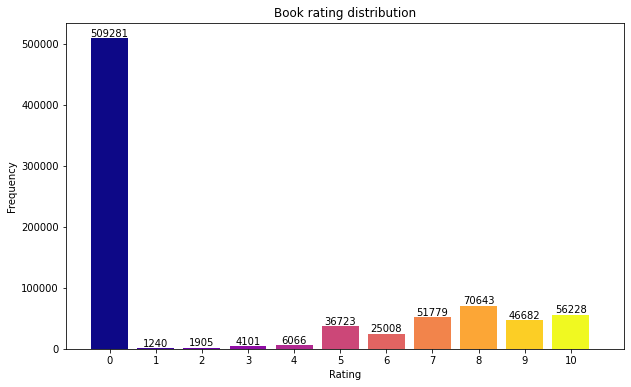

In [34]:
plt.figure(figsize=(10,6))

n, bins, patches = plt.hist(book_ratings_df['Book-Rating'], bins=np.arange(0, 12, 1), width=0.8)
plt.bar_label(patches)

hist_color(bins, patches)
hist_label(patches, np.arange(0, 11, 1))
hist_title('Book rating distribution', 'Rating', 'Frequency')

plt.show()

Nhận xét: 
- Điểm đánh giá có giá trị trong đoạn [0, 10].
- Phần lớn lượt đánh giá có số điểm là 0.
- Phần còn lại, các lượt đánh giá tập trung ở các giá trị lớn hơn trung bình (>= 5)

Ta khám phá điểm đánh giá trung bình của từng người đánh giá.

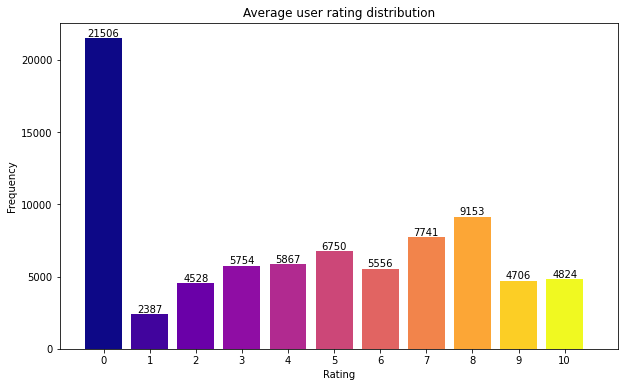

In [35]:
average_rating_per_user = book_ratings_df.groupby('User-ID').agg({'Book-Rating': 'mean'})['Book-Rating'].to_numpy().flatten()

plt.figure(figsize=(10,6))

n, bins, patches = plt.hist(average_rating_per_user, bins=np.arange(0, 12, 1) - 0.4, width=0.8) 
plt.bar_label(patches)

hist_color(bins, patches)
hist_label(patches, np.arange(0, 11, 1))
hist_title('Average user rating distribution', 'Rating', 'Frequency')

plt.show()

Nhận xét: 
- Phần lớn người đánh giá có điểm đánh giá trung bình thấp (< 1)
- Phần còn lại, người đánh giá có xu hướng cho điểm đánh giá cao (>= 5).

Ta khám phá đánh giá trung bình của các cuốn sách.

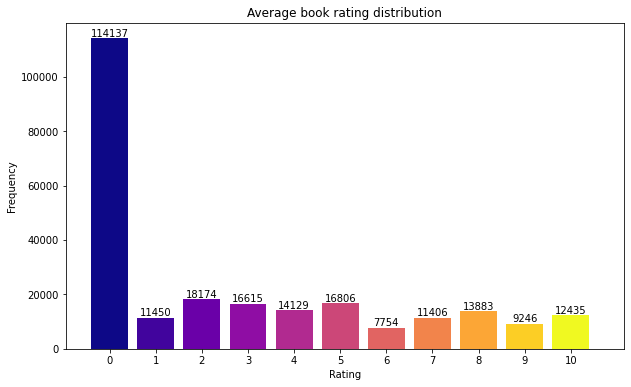

In [36]:
average_rating_per_book = book_ratings_df.groupby('ISBN').agg({'Book-Rating': 'mean'})['Book-Rating'].to_numpy().flatten()

plt.figure(figsize=(10,6))

n, bins, patches = plt.hist(average_rating_per_book, bins=np.arange(0, 12, 1), width=0.8) 
plt.bar_label(patches)

hist_color(bins, patches)
hist_label(patches, np.arange(0, 11, 1))
hist_title('Average book rating distribution', 'Rating', 'Frequency')

plt.show()

Nhận xét: 
- Phần lớn sách được đánh giá có điểm đánh giá trung bình thấp (< 1)
- Phần còn lại, phân phối điểm đánh giá trung bình khá đều.

Ta khám phá số lượt đánh giá của từng người dùng.

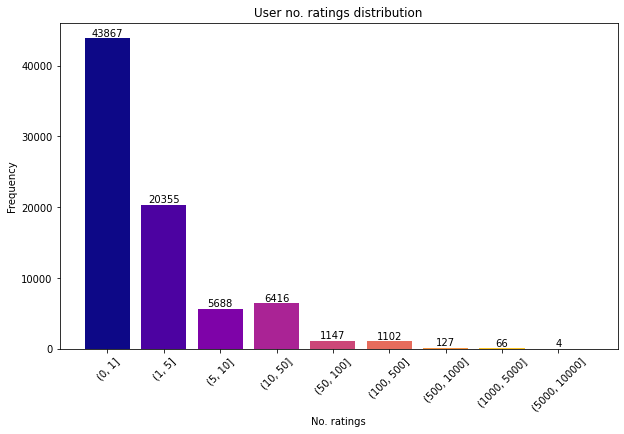

In [37]:
def get_range_index(val):
    if val <= 1:
        return 0
    if val <= 5:
        return 1
    return 2 + get_range_index(val / 10)

num_ratings_per_user = book_ratings_df.groupby('User-ID').agg({'Book-Rating': 'count'})['Book-Rating'].apply(get_range_index).to_numpy()
max_num_ratings_per_user = num_ratings_per_user.max()
tick_labels = []
b = 0
for i in range(max_num_ratings_per_user + 1):
    n = 1 if i % 2 == 0 else 5
    n *= 10 ** (i // 2)
    tick_labels.append(f'({b}, {n}]')
    b = n

plt.figure(figsize=(10,6))

n, bins, patches = plt.hist(num_ratings_per_user, bins=np.arange(0, max_num_ratings_per_user + 2, 1), width=0.8) 
plt.bar_label(patches)

hist_color(bins, patches)
hist_label(patches, tick_labels, rotation=45)
hist_title('User no. ratings distribution', 'No. ratings', 'Frequency')
 
plt.show()

Nhận xét: 
- Hầu hết người đánh giá chỉ có vài lượt đánh giá.
- Có một số ít người đánh giá có rất nhiều lượt đánh giá.

Ta sẽ xem xét kỹ hơn những người dùng có rating trung bình thấp (< 1) so với những người dùng còn lại (>= 1)

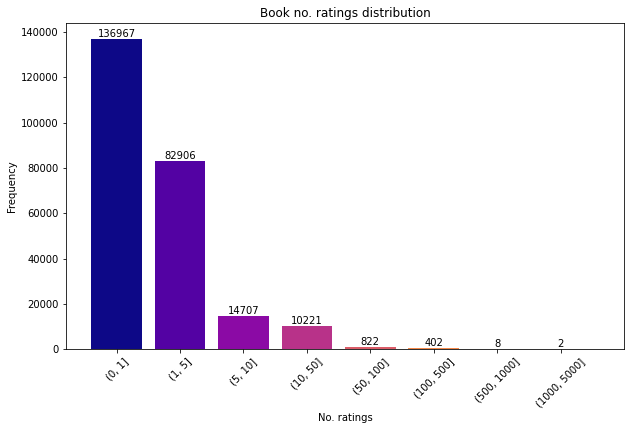

In [38]:
def get_range_index(val):
    if val <= 1:
        return 0
    if val <= 5:
        return 1
    return 2 + get_range_index(val / 10)

num_ratings_per_book = book_ratings_df.groupby('ISBN').agg({'Book-Rating': 'count'})['Book-Rating'].apply(get_range_index).to_numpy()
max_num_ratings_per_book = num_ratings_per_book.max()
tick_labels = []
b = 0
for i in range(max_num_ratings_per_book + 1):
    n = 1 if i % 2 == 0 else 5
    n *= 10 ** (i // 2)
    tick_labels.append(f'({b}, {n}]')
    b = n

plt.figure(figsize=(10,6))

n, bins, patches = plt.hist(num_ratings_per_book, bins=np.arange(0, max_num_ratings_per_book + 2, 1), width=0.8) 
plt.bar_label(patches)

hist_color(bins, patches)
hist_label(patches, tick_labels, rotation=45)
hist_title('Book no. ratings distribution', 'No. ratings', 'Frequency')
 
plt.show()

In [39]:
user_ratings_df = book_ratings_df.groupby('User-ID').agg({'Book-Rating': ['mean', 'count']}).reset_index()
user_ratings_df.columns = [' '.join(col).strip() for col in user_ratings_df.columns.values]

low_rating_users_df  = user_ratings_df[user_ratings_df['Book-Rating mean'] < 1.0]
high_rating_users_df = user_ratings_df[user_ratings_df['Book-Rating mean'] >= 1.0]

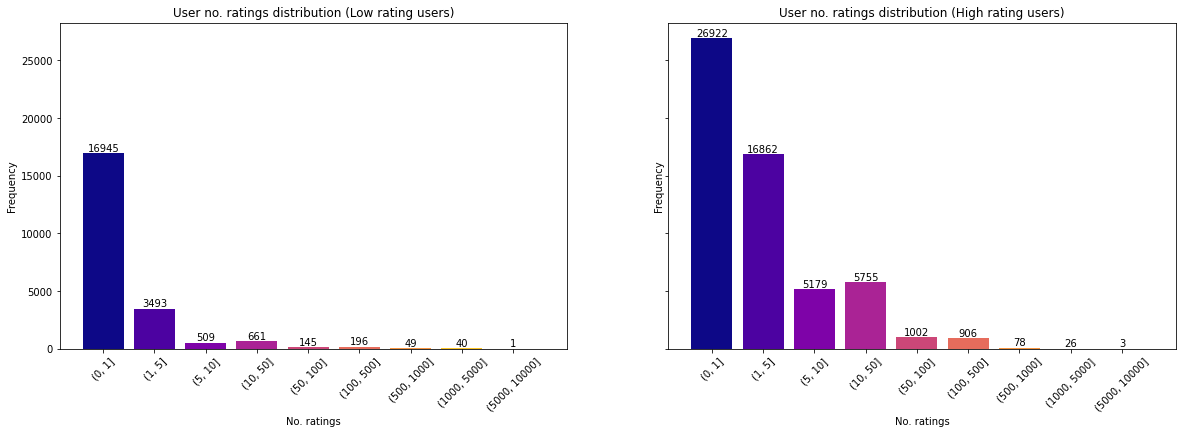

In [40]:
def get_range_index(val):
    if val <= 1:
        return 0
    if val <= 5:
        return 1
    return 2 + get_range_index(val / 10)

fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

num_ratings_per_low_rating_user = low_rating_users_df['Book-Rating count'].apply(get_range_index).to_numpy()
max_num_ratings_per_low_rating_user = num_ratings_per_low_rating_user.max()
tick_labels = []
b = 0
for i in range(max_num_ratings_per_low_rating_user + 1):
    n = 1 if i % 2 == 0 else 5
    n *= 10 ** (i // 2)
    tick_labels.append(f'({b}, {n}]')
    b = n

n, bins, patches = axs[0].hist(num_ratings_per_low_rating_user, bins=np.arange(0, max_num_ratings_per_low_rating_user + 2, 1), width=0.8) 
axs[0].bar_label(patches)

hist_color(bins, patches)
hist_label(patches, tick_labels, ax=axs[0], rotation=45)
hist_title('User no. ratings distribution (Low rating users)', 'No. ratings', 'Frequency', ax=axs[0])

num_ratings_per_high_rating_user = high_rating_users_df['Book-Rating count'].apply(get_range_index).to_numpy()
max_num_ratings_per_high_rating_user = num_ratings_per_high_rating_user.max()
tick_labels = []
b = 0
for i in range(max_num_ratings_per_high_rating_user + 1):
    n = 1 if i % 2 == 0 else 5
    n *= 10 ** (i // 2)
    tick_labels.append(f'({b}, {n}]')
    b = n

n, bins, patches = axs[1].hist(num_ratings_per_high_rating_user, bins=np.arange(0, max_num_ratings_per_high_rating_user + 2, 1), width=0.8) 
axs[1].bar_label(patches)

hist_color(bins, patches)
hist_label(patches, tick_labels, ax=axs[1], rotation=45)
hist_title('User no. ratings distribution (High rating users)', 'No. ratings', 'Frequency', ax=axs[1])


plt.show()

Nhận xét:
- Người có rating trung bình thấp (< 1) có khuynh hướng thực hiện 1 lượt đánh giá.
- Người có rating trung bình cao (>= 1) cũng có khuynh hướng thực hiện 1 lượt đánh giá, nhưng với mức độ nhẹ hơn so với người có rating trung bình thấp.

Ta khám phá số lượng sách của từng tác giả.

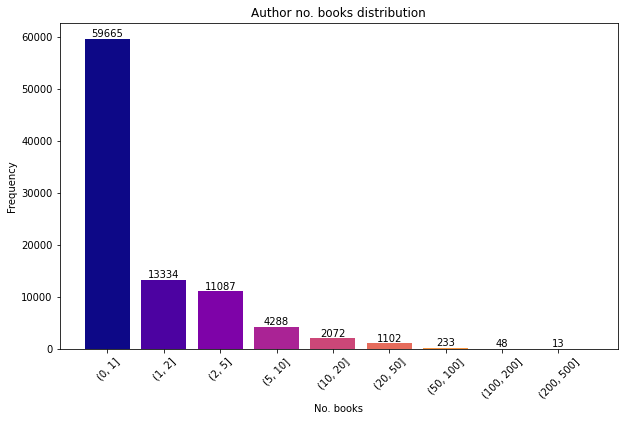

In [41]:
def get_range_index(val):
    if val <= 1:
        return 0
    if val <= 2:
        return 1
    if val <= 5:
        return 2
    return 3 + get_range_index(val / 10)

num_books_per_author = books_df[['ISBN', 'Book-Author']].explode('Book-Author')
num_books_per_author = num_books_per_author.groupby('Book-Author').agg({'ISBN': 'count'})['ISBN'].apply(get_range_index).to_numpy()
max_num_books_per_author = num_books_per_author.max()
tick_labels = []
b = 0
for i in range(max_num_books_per_author + 1):
    n = 1 if i % 3 == 0 else 2 if i % 3 == 1 else 5
    n *= 10 ** (i // 3)
    tick_labels.append(f'({b}, {n}]')
    b = n

plt.figure(figsize=(10,6))

n, bin, patches = plt.hist(num_books_per_author, bins=np.arange(0, max_num_books_per_author + 2, 1), width=0.8) 
plt.bar_label(patches)

hist_color(bins, patches)
hist_label(patches, tick_labels, rotation=45)
hist_title('Author no. books distribution', 'No. books', 'Frequency')

plt.show()

Nhận xét: 
- Hầu hết tác giả chỉ có một vài sách.
- Có một số ít tác giả có rất nhiều sách.

Điều này có thể ảnh hưởng đến mô hình đề xuất dựa trên tác giả vì phần lớn tác giả có ít sách, kéo theo số lượng sách đề xuất cũng ít hơn.

## PHÁT SINH DỮ LIỆU

Ta tổng hợp bộ dự liệu mới, chứa thông tin về đánh giá trung bình và số lượt đánh giá của từng người dùng đối với tất cả các sách từng tác giả.

Mục đích của việc xây dựng bộ dữ liệu này là để xây dựng mô hình lọc cộng tác đề xuất tác giả.

In [42]:
author_ratings_df = pd.merge(book_ratings_df, books_df[['ISBN', 'Book-Author']], on='ISBN').drop('ISBN', axis=1)[['User-ID', 'Book-Author', 'Book-Rating']]
author_ratings_df = author_ratings_df.explode('Book-Author').groupby(['User-ID', 'Book-Author']).agg(['mean', 'count']).rename(columns={'mean': 'Average-Rating', 'count': 'Num-Ratings'}).reset_index()
author_ratings_df.columns = [col[-1] if len(col[-1]) > 0 else col[0] for col in author_ratings_df.columns]
print(author_ratings_df.shape)

author_ratings_df.head()

(653637, 4)


,User-ID,Book-Author,Average-Rating,Num-Ratings
0,2,mark morford,0.0,1
1,8,adam lebor,0.0,1
2,8,amy tan,0.0,1
3,8,carlo d'este,0.0,1
4,8,david richards,0.0,1


In [43]:
author_ratings_df.to_csv('data_preprocessed/author_ratings.csv', index=False)